# Low-shot visual anomaly detection

In this notebook you'll investigate visual anomaly detection in a typical industrial setting - we don't have much data and we can train only only normal (non-anomalous) examples.
Read the [PADIM paper](https://arxiv.org/pdf/2011.08785.pdf) carefully.
The code here is based on the original implementation from its authors.

If you have any questions - please write them on slack in the channel.

### Bibliography

1. Defard, T., Setkov, A., Loesch, A., & Audigier, R. (2021). [Padim: a patch distribution modeling framework for anomaly detection and localization](https://arxiv.org/pdf/2011.08785.pdf). In International Conference on Pattern Recognition (pp. 475-489). Cham: Springer International Publishing.

## Data

In case of any problems - please visit [MVTec AD](https://www.mvtec.com/company/research/datasets/mvtec-ad/downloads) to get the access to the data.

In [1]:
%pip install --quiet gdown  # for those who don't run it on Google Colab
!gdown -q '1r7WJeDb-E5zzgQSOx7F7bNWg8kYX3yKE'
!gdown -q '1Kb420ygkN1iBni5Iy_-psLGNoY0gQFk9'
!gdown -q '12wDP9I3aVIr1qLekWY3GLhQO7c6SRhGn'

In [2]:
from pathlib import Path
import tarfile

DATA_PATH = Path('./mvtec_anomaly_detection')
DATA_PATH.mkdir(exist_ok=True)

for class_name in ['bottle', 'metal_nut', 'transistor']:
    if not (DATA_PATH / class_name).exists():
        with tarfile.open(class_name + '.tar.xz') as tar:
            tar.extractall(path=DATA_PATH)

## PADIM implementation

In [3]:
import os
import random
import time
from pathlib import Path
from random import sample
from typing import cast, Any, Dict, List, Optional, Tuple

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.backends, torch.backends.mps
import torch.nn.functional as F
from numpy.typing import NDArray
from matplotlib import colors
from PIL import Image
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from scipy.spatial.distance import mahalanobis
from scipy.ndimage import gaussian_filter
from skimage import morphology
from skimage.segmentation import mark_boundaries
from torch.utils.data import DataLoader, Dataset
from torchvision.models import wide_resnet50_2, resnet18, Wide_ResNet50_2_Weights, ResNet18_Weights
from torch import nn
from torchvision import transforms as T
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler

FloatNDArray = NDArray[np.float32]

In [4]:
# Leave it as is if you're unsure, this notebook will guess this for you below.
DEVICE: Optional[torch.device] = None
SEED: int = 42  # do not modify

plt.style.use("dark_background")

In [5]:
def seed_all(seed: int = 0) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def get_best_device_for_pytorch() -> torch.device:
    if torch.cuda.is_available():
        device_str = "cuda"     # GPU
    elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        device_str = "mps"      # Apple silicon
    else:
        device_str = "cpu"      # CPU
    return torch.device(device_str)

In [6]:
if not DEVICE:
    DEVICE = get_best_device_for_pytorch()
print(f"Using PyTorch with {DEVICE} backend.")

seed_all(SEED)
print(f"Seeded everything with {SEED}.")

Using PyTorch with cpu backend.
Seeded everything with 42.


### MVTecDataset

In [7]:
class MVTecDataset(Dataset[Tuple[torch.Tensor, int, torch.Tensor]]):
    """MVTec dataset of industrial objects with and without anomalies.

    Yields (x, y, mask) tuples where:
    - x is an RGB image from the class, as float tensor of shape (3, cropsize, cropsize);
    - y is an int, 0 for good images, 1 for anomalous images;
    - mask is 0 for normal pixels, 1 for anomalous pixels, as float tensor of shape (1, cropsize, cropsize).

    Source: https://github.com/xiahaifeng1995/PaDiM-Anomaly-Detection-Localization-master/blob/main/datasets/mvtec.py
    """

    def __init__(self, dataset_path: Path, class_name: str = 'bottle',
                 is_train: bool = True, resize: int = 256, cropsize: int = 224, return_only_indices=False):
        self.dataset_path = dataset_path
        self.class_name = class_name
        assert (dataset_path / class_name).is_dir(), f'Dataset class not found: {dataset_path / class_name}'
        self.is_train = is_train

        self.resize = resize
        self.cropsize = cropsize

        # load dataset
        self.x, self.y, self.mask = self.load_dataset_folder()

        # set transforms
        self.transform_x = T.Compose([T.Resize(resize, Image.LANCZOS),
                                      T.CenterCrop(cropsize),
                                      T.ToTensor(),
                                      T.Normalize(mean=[0.485, 0.456, 0.406],
                                                  std=[0.229, 0.224, 0.225])])
        self.transform_mask = T.Compose([T.Resize(resize, Image.NEAREST),
                                         T.CenterCrop(cropsize),
                                         T.ToTensor()])

        self.return_only_indices = return_only_indices

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int, torch.Tensor]:
        if self.return_only_indices:  # Used for checking the answer of T1.1.
            return idx

        x, y, mask = self.x[idx], self.y[idx], self.mask[idx]

        x = Image.open(x).convert('RGB')
        x = cast(torch.Tensor, self.transform_x(x))

        if y == 0:
            mask = torch.zeros([1, self.cropsize, self.cropsize])
        else:
            assert mask is not None
            mask = Image.open(mask)
            mask = cast(torch.Tensor, self.transform_mask(mask))

        return x, y, mask

    def __len__(self) -> int:
        return len(self.x)

    def load_dataset_folder(self) -> Tuple[List[Path], List[int], List[Optional[Path]]]:
        phase = 'train' if self.is_train else 'test'
        x: List[Path] = []
        y: List[int] = []
        mask: List[Optional[Path]] = []

        img_dir = self.dataset_path / self.class_name / phase
        gt_dir = self.dataset_path / self.class_name / 'ground_truth'

        for img_type_dir in sorted(img_dir.iterdir()):
            # Load images.
            if not img_type_dir.is_dir():
                continue
            img_fpath_list = sorted(img_type_dir.glob('*.png'))
            x.extend(img_fpath_list)

            # Load ground-truth labels and masks.
            if img_type_dir.name == 'good':
                y.extend([0] * len(img_fpath_list))
                mask.extend([None] * len(img_fpath_list))
            else:
                y.extend([1] * len(img_fpath_list))
                mask.extend([gt_dir / img_type_dir.name / (f.stem + '_mask.png')
                            for f in img_fpath_list])

        assert len(x) == len(y) == len(mask), 'Number of x, y, and mask should be the same.'
        return x, y, mask

In [8]:
def sample_idx(number_of_features: int, max_number_of_features: int) -> torch.Tensor:
    assert number_of_features <= max_number_of_features
    return torch.tensor(sample(range(0, max_number_of_features), number_of_features))


def denormalization(x: FloatNDArray) -> NDArray[np.uint8]:
    """Denormalize with ImageNet values."""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    return (((x.transpose(1, 2, 0) * std) + mean) * 255.).astype(np.uint8)


def embedding_concat(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    Concatenate embeddings (along the channel dimension, upscaling y to match x).

    Args:
        x: Tensor of shape (B, C1, H1, W1).
        y: Tensor of shape (B, C2, H2, W2).

    Returns:
        Tensor of shape is (B, C1 + C2, H1, W1).
    """
    B, C1, H1, W1 = x.size()
    _, C2, H2, W2 = y.size()
    s = int(H1 / H2)
    x = F.unfold(x, kernel_size=s, dilation=1, stride=s)
    x = x.view(B, C1, s * s, H2, W2)
    z = torch.zeros(B, C1 + C2, s * s, H2, W2).to(x.device)
    for i in range(s * s):
        z[:, :, i, :, :] = torch.cat((x[:, :, i, :, :], y), dim=1)
    z = z.view(B, -1, H2 * W2)
    z = F.fold(z, kernel_size=s, output_size=(H1, W1), stride=s)
    return z

def concatenate_embeddings_from_all_layers(layer_outputs: Dict[str, torch.Tensor]) -> torch.Tensor:
        embedding_vectors = layer_outputs['layer1']
        for layer_name in ['layer2', 'layer3']:
            embedding_vectors = embedding_concat(embedding_vectors, layer_outputs[layer_name])
        return embedding_vectors

def plot_fig(test_img, scores, gts, threshold: float, save_dir: Path, class_name: str):
    num = len(scores)
    vmax = scores.max() * 255.
    vmin = scores.min() * 255.
    for i in range(num):
        img = test_img[i]
        img = denormalization(img)
        gt = gts[i].transpose(1, 2, 0).squeeze()
        heat_map = scores[i] * 255
        mask = scores[i]
        mask[mask > threshold] = 1
        mask[mask <= threshold] = 0
        kernel = morphology.disk(4)
        mask = morphology.opening(mask, kernel)
        mask *= 255
        vis_img = mark_boundaries(img, mask, color=(1, 0, 0), mode='thick')
        fig_img, ax_img = plt.subplots(1, 5, figsize=(12, 3))
        fig_img.subplots_adjust(right=0.9)
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
        for ax_i in ax_img:
            ax_i.axes.xaxis.set_visible(False)
            ax_i.axes.yaxis.set_visible(False)
        ax_img[0].imshow(img)
        ax_img[0].title.set_text('Image')
        ax_img[1].imshow(gt, cmap='gray')
        ax_img[1].title.set_text('GroundTruth')
        ax = ax_img[2].imshow(heat_map, cmap='jet', norm=norm)
        ax_img[2].imshow(img, cmap='gray', interpolation='none')
        ax_img[2].imshow(heat_map, cmap='jet', alpha=0.5, interpolation='none')
        ax_img[2].title.set_text('Predicted heat map')
        ax_img[3].imshow(mask, cmap='gray')
        ax_img[3].title.set_text('Predicted mask')
        ax_img[4].imshow(vis_img)
        ax_img[4].title.set_text('Segmentation result')
        left = 0.92
        bottom = 0.15
        width = 0.015
        height = 1 - 2 * bottom
        rect = [left, bottom, width, height]
        cbar_ax = fig_img.add_axes(rect)
        cb = plt.colorbar(ax, shrink=0.6, cax=cbar_ax, fraction=0.046)
        cb.ax.tick_params(labelsize=8)
        font = {
            'family': 'serif',
            'color': 'black',
            'weight': 'normal',
            'size': 8,
        }
        cb.set_label('Anomaly Score', fontdict=font)

        fig_img.savefig(save_dir / f'{class_name}_{i}', dpi=100)
        plt.close()

In [9]:
def get_feature_extractor(arch: str) -> nn.Module:
    if arch == 'resnet18':
        model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1, progress=True)
        # t_d = 448
        # d = 40
    elif arch == 'wide_resnet50_2':
        model = wide_resnet50_2(weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1, progress=True)
        # t_d = 1792
        # d = 550
    else:
        raise NotImplementedError
    return model

### PADIM class

In [36]:
class PADIM():

    def __init__(
            self,
            backbone: str,
            device: torch.device,
            save_path: Path,
            backbone_features_idx: torch.Tensor,
            class_names: List[str] = ["bottle"],
            plot_metrics: bool = False,
    ) -> None:
        self.arch = backbone
        self.device = device
        self.model = get_feature_extractor(backbone)
        self.model.to(device)
        self.model.eval()

        self.feature_subset_indices = backbone_features_idx
        self.feature_subset_indices.to(device)

        self.outputs: Dict[str, torch.Tensor] = {}

        self.class_names = class_names
        self.save_path = save_path
        self.plot_metrics = plot_metrics

        self.setup_hooks()
        (self.save_path / f'temp_{self.arch}').mkdir(parents=True, exist_ok=True)

        self.mean: FloatNDArray  # shape (C, H * W)
        self.cov: FloatNDArray  # shape (C, C, H * W)

    def setup_hooks(self):
        """Setup hooks to store model's intermediate outputs."""
        self.model.layer1[-1].register_forward_hook(lambda _, __, x: self.outputs.update({'layer1': x}))
        self.model.layer2[-1].register_forward_hook(lambda _, __, x: self.outputs.update({'layer2': x}))
        self.model.layer3[-1].register_forward_hook(lambda _, __, x: self.outputs.update({'layer3': x}))

    def train_and_test(self, train_dataloader: DataLoader, test_dataloader: DataLoader) -> float:
        self.train(train_dataloader)
        return self.test(test_dataloader)

    def train(self, train_dataloader: DataLoader) -> None:
        self.train_outputs: Dict[str, List[torch.Tensor]] = {'layer1': [], 'layer2': [], 'layer3': []}
        for x, _, _ in tqdm(train_dataloader, desc='Feature extraction (train)'):
            # Run model prediction.
            with torch.no_grad():
                _ = self.model(x.to(DEVICE))
            # Get intermediate layer outputs.
            assert list(self.outputs.keys())  == ['layer1', 'layer2', 'layer3'], list(self.outputs.keys())
            for k, v in self.outputs.items():
                self.train_outputs[k].append(v.cpu().detach())
            # Reset hook outputs.
            self.outputs = {}

        embedding_vectors = concatenate_embeddings_from_all_layers(
            {k: torch.cat(v, 0) for k, v in self.train_outputs.items()})
        embedding_vectors_subset = torch.index_select(embedding_vectors, 1, self.feature_subset_indices.cpu())

        self.mean, self.cov = self.estimate_multivariate_gaussian(embedding_vectors_subset)
        del(self.train_outputs)

    def estimate_multivariate_gaussian(self, embedding_vectors: torch.Tensor
                                       ) -> Tuple[FloatNDArray, FloatNDArray]:
        """Calculates multivariate Gaussian distribution.

        Takes embeddings of shape (N, C, H, W).
        Returns (mean, covariance) of shape (C, H * W) and (C, C, H * W) respectively.
        """
        B, C, H, W = embedding_vectors.size()
        embedding_vectors = embedding_vectors.view(B, C, H * W)
        mean = torch.mean(embedding_vectors, dim=0).numpy()
        cov = torch.zeros(C, C, H * W).numpy()
        I = np.identity(C)
        for i in tqdm(range(H * W), desc="Covariance estimation"):
            cov[:, :, i] = np.cov(embedding_vectors[:, :, i].numpy(), rowvar=False) + 0.01 * I
        return mean, cov

    def test(self, test_dataloader: DataLoader) -> float:
        self.test_outputs: Dict[str, List[torch.Tensor]] = {'layer1': [], 'layer2': [], 'layer3': []}
        test_imgs: List[FloatNDArray] = []
        gt_list: List[NDArray[Any]] = []
        gt_mask_list: List[FloatNDArray] = []

        # Extract test set features.
        for x, y, mask in tqdm(test_dataloader, desc='Feature extraction (test)', disable=False):
            x_shape = x.shape
            test_imgs.extend(x.cpu().detach().numpy())
            gt_list.extend(y.cpu().detach().numpy())
            gt_mask_list.extend(mask.cpu().detach().numpy())
            # Run model prediction.
            with torch.no_grad():
                _ = self.model(x.to(DEVICE))
            # Get intermediate layer outputs.
            assert list(self.outputs.keys())  == ['layer1', 'layer2', 'layer3']
            for k, v in self.outputs.items():
                self.test_outputs[k].append(v.cpu().detach())
            # Reset hook outputs.
            self.outputs = {}
        gt_mask = np.asarray(gt_mask_list)  # shape (len(test_dataset), 1, H, W)

        embedding_vectors = concatenate_embeddings_from_all_layers(
            {k: torch.cat(v, 0) for k, v in self.test_outputs.items()})
        # shape (len(test_dataset), len(feature_subset_indices), H1, W1)
        embedding_vectors_subset = torch.index_select(embedding_vectors, 1, self.feature_subset_indices.cpu())

        distances = self.calculate_distances(embedding_vectors_subset)
        score_map = self.prepare_anomaly_map((x_shape[2], x_shape[3]), distances)

        img_fpr, img_tpr, img_auroc = self.calculate_auroc_image_level(score_map, gt_list)
        pxl_fpr, pxl_tpr, pxl_auroc = self.calculate_auroc_pixel_level(score_map, gt_mask)

        if self.plot_metrics:
            print(f'[TEST] Image AUROC: {img_auroc:.3f}')
            print(f'[TEST] Pixel AUROC: {pxl_auroc:.3f}')
            threshold = self.calculate_optimal_threshold(score_map, gt_mask)
            self.plot_test_results_for_class(gt_mask_list, test_imgs, score_map, threshold, img_fpr, img_tpr, img_auroc, pxl_fpr, pxl_tpr, pxl_auroc)

        return pxl_auroc

    # TODO: Some of your code for Task 1 goes here. You can add more functions if needed, but use the ones below - we will use them for checking your solution.
    def test_permutation_importance(self, val_dataloader: DataLoader, features_to_permute: List[int]) -> List[float]:
        baseline_score = self.test(val_dataloader)
        self.test_outputs = {f'layer{i}': [] for i in range(1, 4)}
        test_imgs, gt_list, gt_mask_list = [], [], []

        for x, y, mask in tqdm(
            val_dataloader,
            desc="Feature extraction (test permutation importance)",
            disable=False,
        ):
            x_shape = x.shape
            test_imgs.extend(x.cpu().detach().numpy())
            gt_list.extend(y.cpu().detach().numpy())
            gt_mask_list.extend(mask.cpu().detach().numpy())
            with torch.no_grad():
                _ = self.model(x.to(DEVICE))
            assert list(self.outputs.keys()) == ["layer1", "layer2", "layer3"]
            for k, v in self.outputs.items():
                self.test_outputs[k].append(v.cpu().detach())
            self.outputs = {}

        ground_truth_mask = np.asarray(gt_mask_list)
        embedding_vectors = concatenate_embeddings_from_all_layers(
            {k: torch.cat(v, 0) for k, v in self.test_outputs.items()}
        )
        embedding_vectors_subset = torch.index_select(
            embedding_vectors, 1, self.feature_subset_indices.cpu()
        )

        auroc_list = []
        for j in features_to_permute:
            vectors_permuted = self.permute_feature(
                embedding_vectors_subset, j
            )
            score_map = self.prepare_anomaly_map((x_shape[2], x_shape[3]), self.calculate_distances(vectors_permuted))
            _, _, auroc = self.calculate_auroc_pixel_level(score_map, ground_truth_mask)
            auroc_list.append(baseline_score - auroc)

        return auroc_list

    def permute_feature(self, embedding_vectors_subset: torch.Tensor, number_of_feature_to_permute: int) -> torch.Tensor:
        permuted_subset = embedding_vectors_subset.clone()
        N, C, H, W = embedding_vectors_subset.size()

        for n in range(N):
            current_feature = permuted_subset[n, number_of_feature_to_permute, :, :]
            rng = torch.Generator().manual_seed(number_of_feature_to_permute * N + n)
            permuted_subset[n, number_of_feature_to_permute, :, :] = current_feature.view(-1)[torch.randperm(H * W, generator=rng)].view(H, W)

        return permuted_subset
    # TODO: End of your code for Task 1 (here)

    def plot_test_results_for_class(self, gt_mask_list, test_imgs,
                                    score_map, threshold: float,
                                    img_fpr, img_tpr, img_auroc: float,
                                    pxl_fpr, pxl_tpr, pxl_auroc: float):
        _, ax = plt.subplots(1, 2, figsize=(8, 4))
        ax[0].plot(img_fpr, img_tpr, label=f'Image AUROC: {img_auroc:.3f}')
        ax[1].plot(pxl_fpr, pxl_tpr, label=f'Pixel AUROC: {pxl_auroc:.3f}')

        save_dir = self.save_path / f'pictures_{self.arch}'
        save_dir.mkdir(parents=True, exist_ok=True)
        plot_fig(test_imgs, score_map, gt_mask_list,
                 threshold, save_dir, "")

    def calculate_auroc_image_level(self, score_map: FloatNDArray, gt_list: List[NDArray[Any]]) -> Tuple[FloatNDArray, FloatNDArray, float]:
        """Calculate image-level AUROC score."""
        img_scores = score_map.reshape(score_map.shape[0], -1).max(axis=1)
        fpr, tpr, _ = roc_curve(gt_list, img_scores)  # false-positive-rates and true-positive-rates for consecutive thresholds (for plotting).
        img_auroc = roc_auc_score(gt_list, img_scores)
        return fpr, tpr, float(img_auroc)

    def calculate_auroc_pixel_level(self, score_map: FloatNDArray, gt_mask: FloatNDArray) -> Tuple[FloatNDArray, FloatNDArray, float]:
        """Calculate per-pixel level AUROC."""
        assert score_map.shape == gt_mask.squeeze().shape, f"{score_map.shape=}, {gt_mask.shape=}"
        fpr, tpr, _ = roc_curve(gt_mask.flatten(), score_map.flatten())
        per_pixel_auroc = roc_auc_score(gt_mask.flatten(), score_map.flatten())
        return fpr, tpr, float(per_pixel_auroc)

    def calculate_optimal_threshold(self, score_map: FloatNDArray, gt_mask: FloatNDArray) -> float:
        """Calculate the optimal threshold with regard to F1 score."""
        assert score_map.shape == gt_mask.squeeze().shape
        precision, recall, thresholds = precision_recall_curve(
            gt_mask.flatten(), score_map.flatten())
        a = 2 * precision * recall
        b = precision + recall
        f1 = np.divide(a, b, out=np.zeros_like(a), where=(b != 0))
        threshold = thresholds[np.argmax(f1)]
        return threshold

    def calculate_distances(self, embedding_vectors: torch.Tensor) -> FloatNDArray:
        """Calculate Mahalanobis distance of each embedding vector from self.mean.

        For embeddings of shape (N, C, H, W), returns shape (N, H, W).
        """
        B, C, H, W = embedding_vectors.size()
        embedding_vectors = embedding_vectors.view(B, C, H * W).numpy()
        dist_list: List[List[np.float64]] = []
        for i in range(H * W):
            mean = self.mean[:, i]
            conv_inv = np.linalg.inv(self.cov[:, :, i])
            dist = [mahalanobis(sample[:, i], mean, conv_inv)
                    for sample in embedding_vectors]
            dist_list.append(dist)

        return np.array(dist_list).transpose(1, 0).reshape(B, H, W)

    def prepare_anomaly_map(self, shape: Tuple[int, int], distances: FloatNDArray) -> FloatNDArray:
        """Upsample distances to `shape`, apply Gaussian smoothing, and normalize to [0,1].

        For distances of shape (N, H, W) and `shape` equal to (H2, W2), returns shape (N, H2, W2).
        """
        dists = torch.Tensor(distances).unsqueeze(1)
        shape = (dists.shape[0],) + shape
        score_map = cast(FloatNDArray, F.interpolate(
            dists, size=shape[2], mode='bilinear', align_corners=False).squeeze().numpy())
        for i in range(score_map.shape[0]):
            score_map[i] = gaussian_filter(score_map[i], sigma=4)

        min_score, max_score = score_map.min(), score_map.max()
        return (score_map - min_score) / (max_score - min_score + 1e-10)

### Let's see whether it works.
Take a look to the `SAVE_PATH` to inspect the results.

========== bottle


Feature extraction (test): 100%|██████████| 42/42 [00:12<00:00,  3.35it/s]


[TEST] Image AUROC: 0.998
[TEST] Pixel AUROC: 0.981


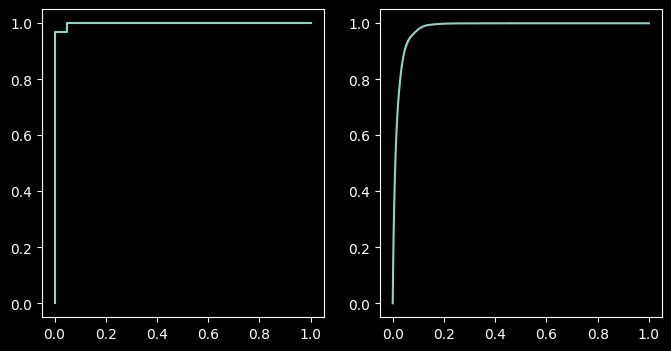

In [37]:
seed_all(SEED)
CLASS_NAMES = [
            'bottle', #'metal_nut'
            # 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather',
            # 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper'
        ]
BATCH_SIZE = 2
RESIZE = 256 * 1
CROP_SIZE = 224 * 1
BACKBONE = "resnet18"
NUMBER_OF_BACKBONE_FEATURES = 50
MAX_NUMBER_OF_BACKBONE_FEATURES = 448

run_timestamp = time.time()
for class_name in CLASS_NAMES:
    print('=' * 10, class_name)
    SAVE_PATH = Path(f"./results/{run_timestamp}/{class_name}")

    train_dataset = MVTecDataset(DATA_PATH, class_name=class_name, is_train=True, resize=RESIZE, cropsize=CROP_SIZE)
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True)
    test_dataset = MVTecDataset(DATA_PATH, class_name=class_name, is_train=False, resize=RESIZE, cropsize=CROP_SIZE)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True)

    padim = PADIM(
        backbone=BACKBONE,
        device=DEVICE,
        backbone_features_idx=sample_idx(NUMBER_OF_BACKBONE_FEATURES, MAX_NUMBER_OF_BACKBONE_FEATURES),
        save_path=SAVE_PATH,
        plot_metrics=True,
    )

    padim.train_and_test(
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
    )

# Task 1. Finding the right features (40%)

The authors of the paper argue that it doesn't really matter how we choose a subset of features. Let's make some steps towards exploring whether it's true for three different classes (`bottle`, `transistor`, `metal_nut`).
Design an experiment which will rank the ResNet18 features by its importance. To do so, we'll implement our variation of [permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html#outline-of-the-permutation-importance-algorithm) on a subset of features produced by the backbone.

## 1.1 Preparing the data
- Using the test dataset, create `val_dataloader` (every even sample from the original test dataset) and `test_dataloader` (every odd sample). `SubsetRandomSampler` might be handy here.
- Then, create 3-fold cross validation-like process in which you'll train PADIM on the first 100 ResNet features in three equally sized subsets of train dataset in which you discard 1/3 of the data ($\texttt{padim.train}(\texttt{train\_dataloader}_k)$) (see below). Again, `SubsetRandomSampler` might be handy here.

In other words, you should have:

- for $k=0$, the first 10 images indexes from the train dataset we should train on are `[1, 2, 4, 5, 7, 8, 10, 11, 13, 14]`,
- for $k=1$, that's `[0, 2, 3, 5, 6, 8, 9, 11, 12, 14]`,
- and for $k=2$, that's `[0, 1, 3, 4, 6, 7, 9, 10, 12, 13]`.

For val and train, you should have `[0, 2, 4, ...]` and `[1, 3, 5, ...]` respectively (from the test dataset).

Don't worry about the sampling order.
Use these names for DataLoaders `val_dataloader`, `test_dataloader`. For k-fold training, store dataloaders in `train_dataloaders: List[DataLoader]`, where each element represent different $k$.
For each class, store the results in `dataloaders` dictionary (defined below) - we will use this to check your solution.

## 1.2 Calculating the importances
- In a given fold, each $j$-th feature shall be ranked based on the pixel-wise AUROC difference between the output of that model ($s_{k} \leftarrow \texttt{padim.test}(\texttt{val\_dataloader})$) and the output with the model with permuted $j$-th feature ($s_{k, j} \leftarrow \texttt{padim.test}(\texttt{val\_dataloader, feature\_to\_permute=}j)$). See also `test_permutation_importance` method stub above.
- Implement `permute_feature` method as follows: given the tensor with embeddings with shape `[B, C, H, W]`, by permutation of the $j$-th feature we mean randomly swapped values for $C=j$. The order of swapping shall be **different** for every image. In other words, for every image $b$ and feature $j$ you need to shuffle the last two dimensions (marked as stars in `[b, j, *, *]`) in an unique manner.
- Then, calculate the mean importance $i$ averaged on these folds and plot weights importance for the class ($i_j \leftarrow s_k -  \frac{1}{K} \sum_{k} s_{k, j}$, where $K$ is the number of folds).
- Append results in `results` dictionary, where keys are class names and values are the lists of averaged feature importances (from feature 0 to feature 99).

## 1.3 Drawing conclusions

- Finally, for every class train three models on the full training data and evaluate it on the `test_dataloader`. The first model shall use the first 10 features, the second shall use worst 10 features (in terms of feature importance), and the third shall contain the best 10 features.
- Write your conclusions (with the things enlisted below in mind). Simply plotting charts or outputting logs without any comment doesn't qualify as an answer to a question.

Note 1: Limit yourself to the first 100 features of ResNet18. If you want, you can go with all of available features instead of 100, but it'll take some time to calculate. Converting parts of the code to PyTorch and running on GPU might change a lot here, but this is not evaluated in this exercise. This experiment can be calculated without GPU in less than one hour anyway.

Note 2: If you'd like to be fully covered, one needs to explore if the features are correlated, as this might bias the results of feature importance calculations. However, this is not evaluated in this task for the sake of simplicity (that is, examining the 100 first features without worrying about correlated features are enough to get 100% from this task).

In [38]:
# do not modify
CLASS_NAMES = ['bottle', 'transistor', 'metal_nut']

BATCH_SIZE = 1
RESIZE = 256 * 2 // 4
CROP_SIZE = 224 * 2 // 4
BACKBONE = "resnet18"
NUMBER_OF_BACKBONE_FEATURES = 10
MAX_NUMBER_OF_BACKBONE_FEATURES = 100  # 448
folds = 3

1702855058.2976701
Class: bottle
  Fold: 0


Feature extraction (test permutation importance): 100%|██████████| 42/42 [00:03<00:00, 10.71it/s]


    Fold Results: [9.743994324344178e-05, 0.00014964345587612873, 3.953134504112536e-06, 0.0003449816640737069, 7.249202694781243e-05, 9.122344653678116e-05, 6.369945969508795e-05, 1.4573996571343173e-05, 0.00023480715706614141, 4.2190908723112784e-05, 0.0009731149342266191, 0.0003855428219005086, 0.0002586796800968146, 0.00032815461546871944, 0.0006622981011894513, 0.00015117315716073332, 7.590077951521075e-05, 0.00017047337530703052, 0.0002547094121489642, 0.00016963841049888462, 0.00015343073295870369, 0.0006381766791414556, 0.0001769436459933734, 0.0002173084423465014, 6.600606941908893e-06, 0.0004797521117558083, 0.0003839667290366222, 0.0001749107281910911, 0.0003465756262247173, 8.739473645576663e-05, 0.00024055903558424982, 0.00011009903289175653, 0.00010093536645235564, 4.68298910503151e-05, 8.257430184484733e-05, 1.1445299298196154e-05, 0.0002470825211246715, 0.00011154274084523852, 0.00015414882410006806, 0.00014971605351332684, 3.1173535787631934e-05, 0.0002992281613493075,

Feature extraction (test permutation importance): 100%|██████████| 42/42 [00:04<00:00, 10.15it/s]


    Fold Results: [8.792007008355067e-05, 0.0001576987749744759, 5.718807376061304e-06, 0.00027918000023430256, 8.814807282179575e-05, 0.00010217928457105045, 5.403603018468613e-05, 2.993246070004396e-05, 0.00022834674500852672, 3.0452568167619692e-05, 0.0008454873598734055, 0.0003918191727751985, 0.00024740345753482273, 0.0003595695246029207, 0.0005143386144864648, 4.69149311298119e-05, 5.817595183684373e-05, 0.00020953138074323677, 0.00017716535225372385, 0.00011479234219994676, 0.0002592669834423263, 0.000627803921715205, 0.00018916056903754233, 8.747113037577137e-05, -4.4005858014968995e-06, 0.0004816069303787603, 0.00031836704583835623, 0.00014087163438906516, 0.00025410556905144005, 0.00010673389576728216, 0.0002482152265533462, 0.00018651604833504662, 0.00011974371512009825, 3.1171069039973944e-05, 0.00010353837053785527, 1.3935802967786811e-05, 0.00021687845060525124, 0.0001304318734075919, 0.00018925480715907086, 0.00019823804982314433, 0.00012166320434040905, 0.00030873803372

Feature extraction (test permutation importance): 100%|██████████| 42/42 [00:03<00:00, 12.37it/s]


    Fold Results: [5.8118271751469074e-05, 0.00016958073041350996, -2.564761971479701e-05, 0.0003385520905424544, 9.891808532154951e-05, 0.00011948881228988444, 4.551891920519709e-05, 0.00012520792069277883, 0.00024121344282738524, 6.707507422561616e-05, 0.0006610094136916267, 0.0004779601157598827, 0.0001779875485071747, 0.00033304143485753573, 0.0004822852358074374, 1.924062319576721e-05, 8.029295328918866e-05, 0.00015646547641342176, 0.00018990062677567052, 0.00011499510885559783, 0.00018406460289666082, 0.0007067169596532974, 0.00015474413810404966, 0.0001851470033972976, 3.1381135596271946e-05, 0.00044885984373166377, 0.00039822142812162564, 0.00015539587791494705, 0.0003761934302687712, 0.00011985505323797163, 0.00015740400281301822, 0.00015837838485277533, 4.887939041383257e-05, 2.2563934314619633e-05, 8.366764801552111e-05, 1.3000897252054186e-05, 0.00026322430723650186, 0.00012564721918018051, 0.00020974235874186378, 0.00013665195735068636, 0.00011259682810016436, 0.0003100538

Feature extraction (test permutation importance): 100%|██████████| 50/50 [00:05<00:00,  9.16it/s]


    Fold Results: [0.00020350843178906786, -0.00029777614078563275, 0.0006181610539610268, 0.0008259983114948429, 0.000675285948476323, 0.0015954122685612655, -0.0001892853843620997, 0.0010322595697045782, 0.0006332909326934866, 0.00027161642423593574, -1.852150065628777e-05, 0.0004216861302804853, 0.0009799218750663103, -0.00030836525899802236, 0.00011669894880509772, 0.00022636986723197547, 0.0005126358120128849, 0.00029599542500387727, 0.0004523018524549653, -0.0007248991780265021, 0.0016413825514850118, -7.415435358278562e-06, 0.0005511230765265681, 0.0003832138509062277, 7.763567425526456e-05, 4.872971333721073e-05, 2.2002857895257282e-05, 4.659425418222322e-05, 0.0014511408460965065, 0.001492117596425942, 0.0009577470939612365, 0.00017057203150383504, 0.00023034131678256742, 0.00010586548286580418, 0.00037512880141251276, -2.8767701249710065e-05, 0.00039244174216590544, 0.00015729356710984335, 0.0001782496665779787, 0.0005275376665084449, 0.0013607598463818797, -0.000342542727211

Feature extraction (test permutation importance): 100%|██████████| 50/50 [00:06<00:00,  7.79it/s]


    Fold Results: [0.00016406184044500302, -0.00021946075991459887, 0.0006551720664987881, 0.00022137779000260446, 0.00045963109949320735, 0.0013976387717538434, -0.0001526372184353919, 0.0006749979251747437, 0.0012449405888860232, 0.00027013208364893665, 0.000175282484649301, 0.0009510468936750893, 0.0005106564279481937, -0.0004323731821198236, 0.0006678510741231122, 0.00025167399741117996, 0.000574132461881612, -0.0001584591900906096, 0.00037908291091159896, -0.0004792240705267699, 0.0013832694857484062, 0.00033698270661726887, 0.0011073120735974884, 0.00026178368623693454, 0.00011539544645233768, -7.729274932274007e-06, -0.00012045506285318641, 0.00030242304787142515, 0.0013496503803567632, 0.0016101191407232873, 0.0006956995624953777, 0.00018594788884951363, 0.0006345948811631308, 0.0001849752662731093, 0.0004211993363084643, -7.138436994576687e-05, 0.00034965893515270796, 0.00017488108183760787, 0.0004815259678480066, 0.0002635766446362764, 0.001235840418697361, -0.000329480351599

Feature extraction (test permutation importance): 100%|██████████| 50/50 [00:05<00:00,  9.56it/s]


    Fold Results: [0.0001139693789696435, -5.882772267651326e-05, 0.0006738305323531479, 0.0006952666023989362, 0.0007681492376293194, 0.001057817723227883, -0.00012215694758688223, 0.0009583588811091411, 0.0009781292311427843, 0.00020467126836768804, 1.7836616159283558e-05, 0.00021955177507319382, 0.00046497045312295554, -0.00035979306533318045, 0.0004891946805843927, 0.00025341361924554234, 0.000454595624598005, 0.0006529610015014361, 0.0003318198251269407, -5.0102415001288904e-05, 0.0006102671545836769, 0.00010648758920928092, 0.00045872017268840565, 0.00016564514584712273, -2.207993372915773e-06, -7.066212864444606e-05, -0.0003026528858294242, 0.00015099239278304477, 0.001488411930153144, 0.001299777079287671, 0.0005539233083516152, 0.00042128572940347553, 0.000669353573861442, 7.985876246840995e-05, 0.0003272604373984282, 2.9115131231346087e-05, 0.0006376853668742521, 0.00016920428100578958, 0.0006778264963922901, 0.0007647413068421205, 0.0017035044232020697, -0.000180164239366287

Feature extraction (test permutation importance): 100%|██████████| 58/58 [00:04<00:00, 12.45it/s]


    Fold Results: [0.0007845789304435172, 0.0006202778898948639, 0.0011949548783614465, 0.0020421977260736135, 0.0017233425487117593, 0.0002573375230593052, 0.0005664340844262113, 0.0005476098944912078, 0.0017051797712273054, 0.00038080202518309125, 0.0005648165543636896, 0.0010110174344591567, 0.0007246962119918191, 0.00022038682562038522, 0.003685079074069416, 0.00030954222509401347, 0.00039123942439515486, 0.0006402697610711957, 0.0005836961361311473, 0.0006032228439942777, 0.0015207312205355317, 0.0004726316421655256, 0.000825382470915977, 0.00020437020584747798, 0.00019737438226093604, 0.0007603244897808429, 0.002270597087949929, 0.0002671562838326332, 0.0006905624330091342, 0.0006721265937780959, 0.0008841604271242106, 0.000318872740747822, 0.000631227701705761, 0.0006329603256046331, 0.00022232117955367503, 0.00019269033653912526, 0.0011201592742431006, 0.0010576152462831168, 0.00041115116090325216, 0.0006526603809104229, 0.0006962022711413848, 0.0001365215325114244, 0.000447364

Feature extraction (test permutation importance): 100%|██████████| 58/58 [00:04<00:00, 13.73it/s]


    Fold Results: [0.0007794737862203416, 0.0005894847965049651, 0.001050319136576013, 0.0017124246591866399, 0.0015067567214909945, 0.000231566617475365, 0.0004974020451271599, 0.00044656744229461715, 0.0016644593872962021, 0.0003861667102725101, 0.000544632861794366, 0.00099195519197659, 0.0007469770769110337, 0.0001895472384131717, 0.003507198099031513, 0.0003037409669119547, 0.0003388737901128813, 0.0006176852479475118, 0.000463348615946176, 0.0007513549853857363, 0.0012011028439364857, 0.0005135648805260443, 0.0008422198068775236, 0.0001984471146519636, 0.0002151863022801607, 0.0008184120005435558, 0.0021658429727247817, 0.00021820883818035597, 0.0006109019836074703, 0.0008646584721030784, 0.0008649719614071497, 0.00028696225728760033, 0.0006903625766360166, 0.0006298396964051397, 0.00024641030525240915, 0.00016365154548469985, 0.0009948411432201636, 0.0010446095952409973, 0.00046230770077578437, 0.0005436200515436621, 0.0005470894919400818, 0.00013890253328123028, 0.0003069685799

Feature extraction (test permutation importance): 100%|██████████| 58/58 [00:04<00:00, 11.68it/s]


    Fold Results: [0.0006712914261322034, 0.0006018060658599852, 0.001143329135171604, 0.0017259810315717328, 0.001691545232894054, 0.00023884771537800256, 0.0005063182439829136, 0.0005699229193435092, 0.0017579936658461321, 0.0003867872073632557, 0.0007211933433762437, 0.0009564161319857156, 0.0007201344595686813, 0.00024894355538799634, 0.0034993574393064795, 0.0002557631922721626, 0.00038188280756360865, 0.0006859327985119604, 0.0005831238814415126, 0.0005600980597901076, 0.0013737242140147525, 0.0005557163939865865, 0.0008127895406825717, 0.00020107005537876402, 0.00022991355288818718, 0.0008579099242807345, 0.0020741655951019475, 0.00020114998491997196, 0.0006684925513595896, 0.0006500022358635338, 0.0009156426751594596, 0.0002504607932883503, 0.0006546728482592264, 0.000600574817719172, 0.00015984418063904235, 0.00015477067352491028, 0.0010659646038045552, 0.0009384541439526976, 0.0004124112294071984, 0.0006187932697112967, 0.0006370980101859288, 0.00016052372182599287, 0.0003860

Feature extraction (test): 100%|██████████| 83/83 [00:07<00:00, 10.58it/s]


[TEST] Image AUROC: 0.998
[TEST] Pixel AUROC: 0.972


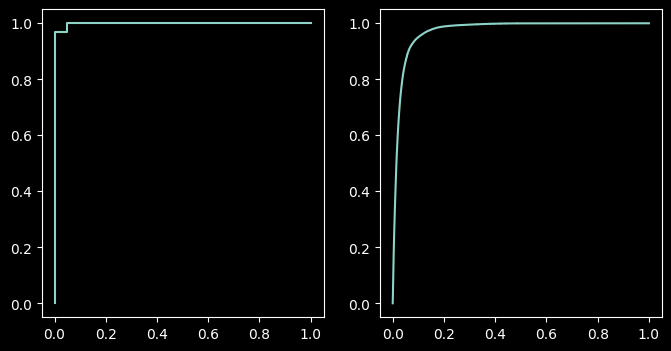

Processing worst_10


Feature extraction (test): 100%|██████████| 83/83 [00:06<00:00, 12.22it/s]


[TEST] Image AUROC: 0.983
[TEST] Pixel AUROC: 0.957


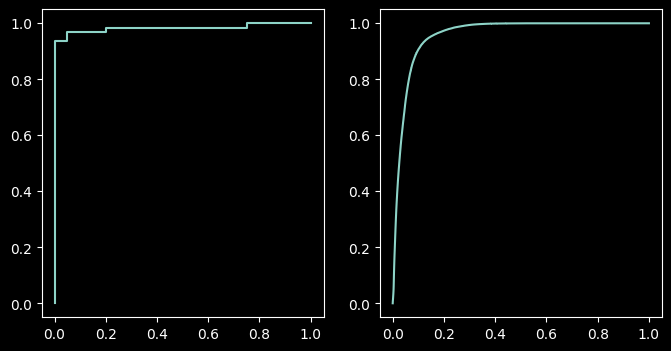

Processing best_10


Feature extraction (test): 100%|██████████| 83/83 [00:07<00:00, 10.40it/s]


[TEST] Image AUROC: 0.996
[TEST] Pixel AUROC: 0.975


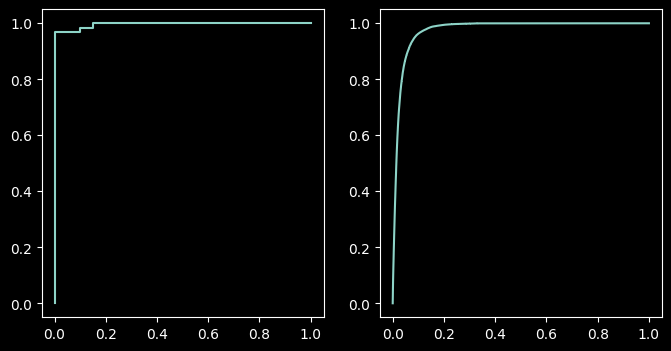

Class: transistor
Processing first_10


Feature extraction (test): 100%|██████████| 100/100 [00:11<00:00,  8.38it/s]


[TEST] Image AUROC: 0.942
[TEST] Pixel AUROC: 0.954


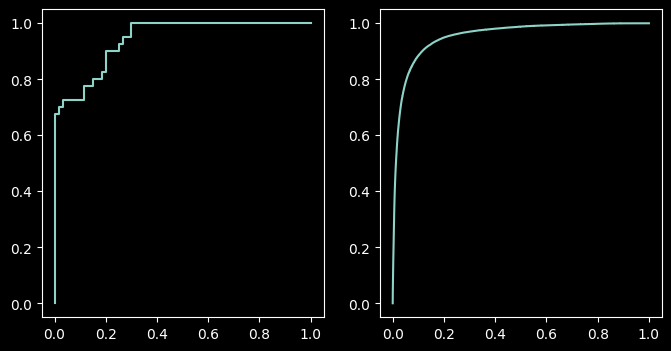

Processing worst_10


Feature extraction (test): 100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


[TEST] Image AUROC: 0.902
[TEST] Pixel AUROC: 0.935


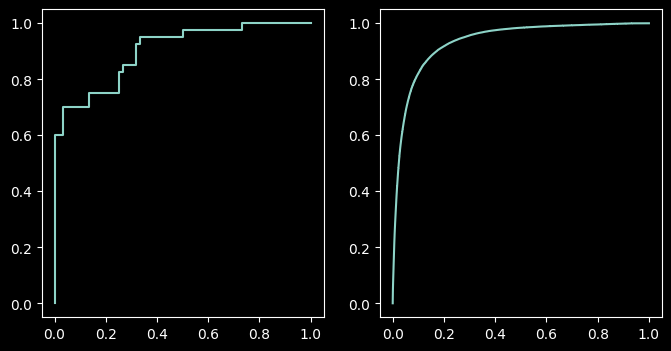

Processing best_10


Feature extraction (test): 100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


[TEST] Image AUROC: 0.897
[TEST] Pixel AUROC: 0.950


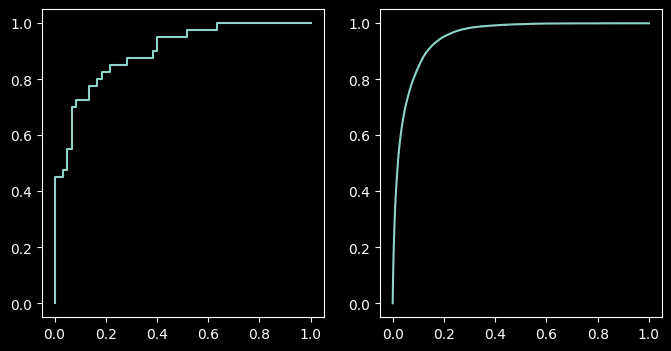

Class: metal_nut
Processing first_10


Feature extraction (test): 100%|██████████| 115/115 [00:09<00:00, 12.50it/s]


[TEST] Image AUROC: 0.911
[TEST] Pixel AUROC: 0.937


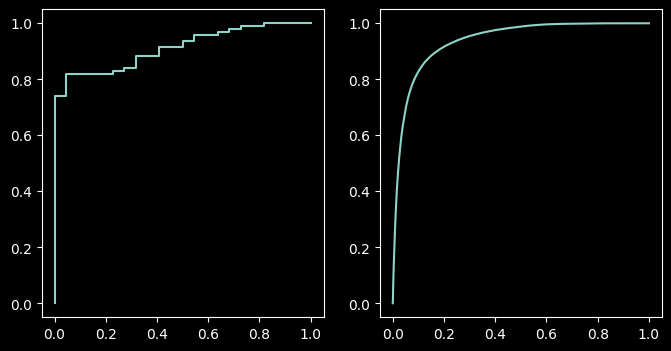

Processing worst_10


Feature extraction (test): 100%|██████████| 115/115 [00:16<00:00,  7.03it/s]


[TEST] Image AUROC: 0.866
[TEST] Pixel AUROC: 0.873


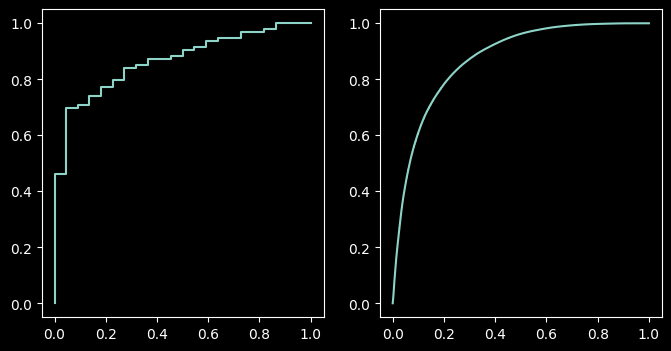

Processing best_10


Feature extraction (test): 100%|██████████| 115/115 [00:11<00:00, 10.44it/s]


[TEST] Image AUROC: 0.861
[TEST] Pixel AUROC: 0.915


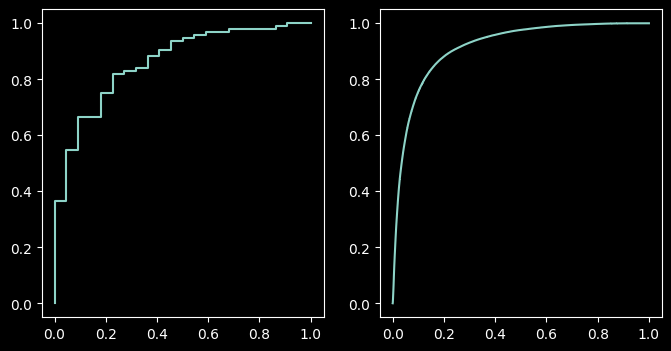

In [39]:
seed_all(SEED)
results = {c: [0] * MAX_NUMBER_OF_BACKBONE_FEATURES for c in CLASS_NAMES}

run_timestamp = time.time()
print(f"{run_timestamp}")

idx_all_fatures = torch.Tensor(range(MAX_NUMBER_OF_BACKBONE_FEATURES)).int()
idx_first_n_features = torch.Tensor(range(NUMBER_OF_BACKBONE_FEATURES)).int()

dataloaders = {c: {"val_dataloader": None, "test_dataloader": None, "train_dataloaders": None} for c in CLASS_NAMES}

# TODO: Your code for T1.1, T1.2, and T1.3 goes below. Don't forget to write `test_permutation_importance` and `permute_feature` above in the PADIM code.
# T1.1
for class_name in CLASS_NAMES:
    train_dataset = MVTecDataset(DATA_PATH, class_name=class_name, is_train=True, resize=RESIZE, cropsize=CROP_SIZE)
    test_dataset = MVTecDataset(DATA_PATH, class_name=class_name, is_train=False, resize=RESIZE, cropsize=CROP_SIZE)

    even_sampler = SubsetRandomSampler(range(0, len(test_dataset), 2))
    odd_sampler = SubsetRandomSampler(range(1, len(test_dataset), 2))

    dataloaders[class_name]["val_dataloader"] = DataLoader(test_dataset, batch_size=BATCH_SIZE, sampler=even_sampler)
    dataloaders[class_name]["test_dataloader"] = DataLoader(test_dataset, batch_size=BATCH_SIZE, sampler=odd_sampler)

    dataloaders[class_name]["train_dataloaders"] = [
        DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler([i for i in range(len(train_dataset)) if i % 3 != k]))
        for k in range(folds)
    ]

# T1.2
run_timestamp = time.time()
for class_name in CLASS_NAMES:
    print(f"Class: {class_name}")
    for fold_index in range(folds):
        print(f"  Fold: {fold_index}")
        save_path = Path(f"./results/{run_timestamp}/{class_name}")
        padim = PADIM(BACKBONE, DEVICE, save_path, idx_all_fatures, [class_name])
        padim.train(dataloaders[class_name]["train_dataloaders"][fold_index])
        fold_results = [res / folds for res in padim.test_permutation_importance(dataloaders[class_name]["val_dataloader"], list(range(MAX_NUMBER_OF_BACKBONE_FEATURES)))]
        print(f"    Fold Results: {fold_results}")
        results[class_name] = [r + f for r, f in zip(results[class_name], fold_results)]

# T1.3
for class_name in CLASS_NAMES:
    train_dataset = MVTecDataset(
        DATA_PATH,
        class_name=class_name,
        is_train=True,
        resize=RESIZE,
        cropsize=CROP_SIZE,
    )
    test_dataset = MVTecDataset(
        DATA_PATH,
        class_name=class_name,
        is_train=False,
        resize=RESIZE,
        cropsize=CROP_SIZE,
    )
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True)

    print(f"Class: {class_name}")
    worst_features, best_features = pd.Series(results[class_name]).nsmallest(10).index, pd.Series(results[class_name]).nlargest(10).index

    for feature_set, feature_label in zip([idx_first_n_features, worst_features, best_features], ["first_10", "worst_10", "best_10"]):
        SAVE_PATH = Path(f"./results/{class_name}/{feature_label}")
        print(f"Processing {feature_label}")
        padim = PADIM(
            backbone=BACKBONE,
            device=DEVICE,
            backbone_features_idx=torch.Tensor(feature_set).int(),
            save_path=SAVE_PATH,
            plot_metrics=True,
        )
        padim.train_and_test(
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
        )
        plt.show()

# Drawing Conclusions and Additional Insights

## Classifiers Evaluation:

In the assessment of classifiers trained on various feature subsets for each class, the results yield valuable insights:

| **Class**       | **Subset**        | **Metric**      | **Value** |
|------------------|-------------------|-----------------|-----------|
| **Bottle**       | **First 10**      | Image AUROC     | 0.998     |
|                  |                   | Pixel AUROC     | 0.972     |
|                  | **Worst 10**      | Image AUROC     | 0.983     |
|                  |                   | Pixel AUROC     | 0.957     |
|                  | **Best 10**       | Image AUROC     | 0.996     |
|                  |                   | Pixel AUROC     | 0.975     |
| **Transistor**   | **First 10**      | Image AUROC     | 0.942     |
|                  |                   | Pixel AUROC     | 0.954     |
|                  | **Worst 10**      | Image AUROC     | 0.902     |
|                  |                   | Pixel AUROC     | 0.935     |
|                  | **Best 10**       | Image AUROC     | 0.897     |
|                  |                   | Pixel AUROC     | 0.950     |
| **Metal Nut**    | **First 10**      | Image AUROC     | 0.911     |
|                  |                   | Pixel AUROC     | 0.937     |
|                  | **Worst 10**      | Image AUROC     | 0.866     |
|                  |                   | Pixel AUROC     | 0.873     |
|                  | **Best 10**       | Image AUROC     | 0.861     |
|                  |                   | Pixel AUROC     | 0.915     |


## General Observations:

- For most classes, classifiers using the first 10 features demonstrate high AUROC scores, indicating strong predictive power.

- Classifiers employing the least important (worst) 10 features exhibit lower AUROC scores, suggesting these features are less informative for the classification task. Although on the image level in Transistor and Metal Nut classes it scored better than best 10 features.

- Classifiers utilizing the best 10 features also achieve high AUROC scores, confirming their significance for the classification task.

- Results vary between classes, suggesting different feature subsets may be more or less relevant depending on the type of object.

## Additional Insights:

### Sensitivity to Feature Selection:

The experiments unveil a sensitivity of the model's performance to the choice of features across all classes, underscoring the importance of thoughtful feature selection in the PADIM model.

### Image AUROC Discrepancies:

Notably, there are instances where the first 10 features outperform the best-performing features in terms of Image and/or Pixel AUROC scores. This observation raises intriguing questions about the architecture's initial features and their potential impact on specific aspects of image classification, indicating certain early features in the ResNet architecture capture essential information for certain classes.

### Overall Implications:

In conclusion, the feature selection process emerges as a critical determinant of the PADIM model's anomaly detection capabilities. While the difference between the best features and the first 10 features is marginal, the substantial performance drop for the 10 worst features underscores the importance of feature quality. This highlights the significance of tailoring feature selection strategies to the unique characteristics of the dataset and the intricacies of the classification task.

### Practical Recommendations:

These findings underscore the need for a nuanced approach to feature selection, considering not only the overall importance but also the class-specific impact of features. Moreover, the potential influence of early features in deep architectures suggests exploring model interpretability techniques to gain insights into feature relevance. Future iterations of the model may benefit from a more dynamic feature selection strategy that adapts to the intricacies of different classes within the dataset.


In [40]:
# Run at the end, but do not modify - we will use this to asses your output.
for c in CLASS_NAMES:
    s = pd.Series(results[c])
    print(s.sort_values(ascending=False)[:10].index.tolist())
    print(s.sort_values(ascending=True)[:10].index.tolist())

def get_sorted_indices(loader):
    loader.dataset.return_only_indices = True
    indices = sorted([x.item() for x in loader])
    loader.dataset.return_only_indices = False
    return indices

for c in CLASS_NAMES:
    print(get_sorted_indices(dataloaders[c]["val_dataloader"]))
    print(get_sorted_indices(dataloaders[c]["test_dataloader"]))
    for v in dataloaders[c]["train_dataloaders"]:
        print(get_sorted_indices(v))

[44, 95, 51, 87, 60, 10, 21, 14, 43, 57]
[62, 91, 73, 67, 2, 84, 24, 96, 35, 74]
[87, 65, 85, 29, 40, 28, 5, 20, 46, 99]
[98, 19, 47, 44, 13, 45, 55, 71, 59, 54]
[14, 87, 26, 95, 57, 3, 8, 89, 4, 83]
[79, 76, 69, 73, 99, 68, 97, 90, 91, 41]
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82]
[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81]
[1, 2, 4, 5, 7, 8, 10, 11, 13, 14, 16, 17, 19, 20, 22, 23, 25, 26, 28, 29, 31, 32, 34, 35, 37, 38, 40, 41, 43, 44, 46, 47, 49, 50, 52, 53, 55, 56, 58, 59, 61, 62, 64, 65, 67, 68, 70, 71, 73, 74, 76, 77, 79, 80, 82, 83, 85, 86, 88, 89, 91, 92, 94, 95, 97, 98, 100, 101, 103, 104, 106, 107, 109, 110, 112, 113, 115, 116, 118, 119, 121, 122, 124, 125, 127, 128, 130, 131, 133, 134, 136, 137, 139, 140, 142, 143, 145, 146, 148, 149, 151, 1

# Task 2. Improving PADIM with Online Covariance Estimation

This implementation of PADIM can be improved in numerous ways. In this exercise, you'll try to indicate its shortcomings and provide some means to mitigate them.

#### 2.1. PADIM's training complexity (15%)

- Identify the key operations contributing to the algorithm's training space complexity *in this implementation*. Don't focus on the backbone, as it is not the part of the algorithm (however, its output is).
- Shortly discuss the implications for scalability. You can support your claims by charts if needed.

*Hint: this doesn't need to be super formal analysis - it's about fiding the "worst" parts of this implementation. You can support your claims with a chart and brief description (e.g. "X dominates the complexity, as it's quadratic.")*

```Your answer to task 2.1 goes here```
# 2.1. PADIM's Training Complexity

In this implementation of PADIM, the key operations contributing to the algorithm's training space complexity are identified in the following sections:

1. **Feature Extraction (Train):**
   - Iterating through the training dataloader and running the model prediction.
   - Storing intermediate layer outputs for `layer1`, `layer2`, and `layer3`.

2. **Estimating Multivariate Gaussian:**
   - Calculating mean and covariance for each feature.

The space complexity is dominated by the storage of intermediate layer outputs during training and the covariance estimation. The storage of these outputs is proportional to the number of samples in the training dataset and the size of intermediate layers.

## Implications for Scalability:

1. **Intermediate Layer Outputs Storage:**
   - As the dataset size increases, the space required to store intermediate layer outputs also increases linearly, impacting memory consumption.
   - Implication: The algorithm may face challenges when dealing with large datasets that do not fit into memory.

2. **Covariance Estimation:**
   - The covariance estimation involves nested loops over the height and width of the embedding vectors.
   - As the spatial dimensions increase, the complexity becomes quadratic.
   - Implication: Scalability may be affected for datasets with large spatial dimensions, leading to longer training times.


**Recommendations:**
- Consider optimizations for intermediate layer output storage, such as selective storage or downsampling for large datasets.
- Explore strategies to optimize covariance estimation, possibly leveraging parallelization or approximations to handle larger spatial dimensions efficiently.


In [ ]:
# Your code goes here (if needed)

#### 2.2 Online mean and covariance (35%)
Implement a PyTorch version of [online covariance matrix estimation](https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Online) in the training as an alternative to the current method in PADIM.
Calculate the mean in an online fashion as well.
Your implementation shall run on the selected `torch.device` (such as GPU).
No need to reimplement the testing routine to online in this exercise (although it'd be nice to have for Task 1), albeit small changes might be necessary (such as conversion from `torch.Tensor` to `np.ndarray`).

Passing criteria:
```python
torch.allclose(padim_online.mean, torch.Tensor(padim_offline.mean).to(DEVICE), atol=0.01)
torch.allclose(padim_online.cov, torch.Tensor(padim_offline.cov).to(DEVICE), atol=0.01)
```


In [ ]:
class PADIMWithOnlineCovariance(PADIM):

    ### TODO: Your code goes here
    def __init__(
            self,
            backbone: str,
            device: torch.device,
            save_path: Path,
            backbone_features_idx: List[int],
            class_names=...,
            plot_metrics=False,
            ) -> None:
        super().__init__(backbone, device, save_path, backbone_features_idx, class_names, plot_metrics)

    def train(self, train_dataloader: DataLoader, C: int, H: int, W: int):
        """C, H, W come from the size of embeddings: [B, C, H, W]"""
        self.mean_prefix, self.mean_prefix_prev, self.mean = torch.zeros((3, C, H * W), device=DEVICE)
        self.cov = torch.zeros(C, C, H*W).to(DEVICE)
        self.train_outputs = {f'layer{i}': [] for i in range(1, 4)}
        N = len(train_dataloader)
        k = 0
        for x, _, _ in tqdm(train_dataloader, desc='Feature extraction (train)'):
            with torch.no_grad():
                _ = self.model(x.to(DEVICE))
            assert list(self.outputs.keys())  == ['layer1', 'layer2', 'layer3'], list(self.outputs.keys())
            outs = torch.index_select(concatenate_embeddings_from_all_layers(self.outputs), 1, self.feature_subset_indices).view(C, H*W)
            self.mean += outs / N
            k += 1
            self.mean_prefix_prev = self.mean_prefix
            self.mean_prefix = ((k - 1) * self.mean_prefix + outs) / k
            for i in range(H*W):
                update = torch.ger((outs[:, i] - self.mean_prefix_prev[:, i]), (outs[:, i] - self.mean_prefix[:, i]))
                self.cov[:, :, i] += update
            self.outputs = {}
        self.cov /= N
        for i in range(H*W):
            self.cov[:, :, i] += 0.01 * torch.eye(C).to(DEVICE)
    ### END OF YOUR CODE


In [ ]:
# do not modify
seed_all(SEED)
class_name = 'bottle'
BATCH_SIZE = 1
RESIZE = 256 * 1
CROP_SIZE = 224 * 1
BACKBONE = "resnet18"
NUMBER_OF_BACKBONE_FEATURES = 30
MAX_NUMBER_OF_BACKBONE_FEATURES = 448
# DEVICE="cpu"

indices = sample_idx(NUMBER_OF_BACKBONE_FEATURES, MAX_NUMBER_OF_BACKBONE_FEATURES).to(DEVICE)

run_timestamp = time.time()
SAVE_PATH = Path(f"./results/{run_timestamp}/{class_name}")

train_dataset = MVTecDataset(DATA_PATH, class_name=class_name, is_train=True, resize=RESIZE, cropsize=CROP_SIZE)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True)
test_dataset = MVTecDataset(DATA_PATH, class_name=class_name, is_train=False, resize=RESIZE, cropsize=CROP_SIZE)
val_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True)


padim_offline = PADIM(
    backbone=BACKBONE,
    device=DEVICE,
    backbone_features_idx=indices,
    save_path=SAVE_PATH,
    plot_metrics=True,
)
padim_offline.train(train_dataloader)

padim_online = PADIMWithOnlineCovariance(
    backbone=BACKBONE,
    device=DEVICE,
    backbone_features_idx=indices,
    save_path=SAVE_PATH,
    plot_metrics=True,
)
padim_online.train(train_dataloader, NUMBER_OF_BACKBONE_FEATURES, int(CROP_SIZE/4), int(CROP_SIZE/4))

torch.allclose(padim_online.mean, torch.Tensor(padim_offline.mean).to(DEVICE), atol=0.01) and torch.allclose(padim_online.cov, torch.Tensor(padim_offline.cov).to(DEVICE), atol=0.01)

Feature extraction (train): 100%|██████████| 209/209 [00:47<00:00,  4.44it/s]


True

#### 2.3 Performance experiments (10%)
If you completed task 2.2, design experiments to empirically compare space and memory performance of PADIM training with both traditional and online covariance matrix estimation. Write short conclusions.

In [ ]:
%pip install memory_profiler
from memory_profiler import profile
%load_ext memory_profiler

class_name = 'bottle'
run_timestamp = time.time()
SAVE_PATH = Path(f"./results/{run_timestamp}/{class_name}")

def create_dataloaders(subset_percent):
    train_sampler = SubsetRandomSampler(range(0, len(train_dataset), int(1/subset_percent)))
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
    return train_dataloader

padim_offline = PADIM(
    backbone=BACKBONE,
    device=DEVICE,
    backbone_features_idx=indices,
    save_path=SAVE_PATH,
    plot_metrics=True,
)

padim_online = PADIMWithOnlineCovariance(
    backbone=BACKBONE,
    device=DEVICE,
    backbone_features_idx=indices,
    save_path=SAVE_PATH,
    plot_metrics=True,
)

def offline_training(train_dataloader):
    print(f'===== Offline Training ({subset_percent*100}%) =====')
    padim_offline.train(train_dataloader)

def online_training(train_dataloader):
    print(f'===== Online Training ({subset_percent*100}%) =====')
    padim_online.train(train_dataloader, NUMBER_OF_BACKBONE_FEATURES, int(CROP_SIZE/4), int(CROP_SIZE/4))

for subset_percent in [0.2, 0.4, 0.6, 0.8, 1.0]:
    train_dataloader = create_dataloaders(subset_percent)
    print('\n' + '=' * 10 + f' Dataset Size: {subset_percent*100}% ' + '=' * 10 + '\n')
    print('\n' + '=' * 10 + ' MEMORY USAGE ' + '=' * 10 + '\n')
    %memit offline_training(train_dataloader)
    %memit online_training(train_dataloader)
    print('\n' + '=' * 10 + ' TIME COMPLEXITY ' + '=' * 10 + '\n')
    %timeit -r 1 -n 2 offline_training(train_dataloader)
    %timeit -r 1 -n 2 online_training(train_dataloader)


The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler

========== Dataset Size: 20.0% ==========


========== MEMORY USAGE ==========

===== Offline Training (20.0%) =====


Covariance estimation: 100%|██████████| 3136/3136 [00:00<00:00, 8765.41it/s]


peak memory: 2603.95 MiB, increment: 568.22 MiB
===== Online Training (20.0%) =====


Feature extraction (train): 100%|██████████| 42/42 [00:10<00:00,  4.06it/s]


peak memory: 2035.72 MiB, increment: 0.00 MiB

========== TIME COMPLEXITY ==========

===== Offline Training (20.0%) =====


Covariance estimation: 100%|██████████| 3136/3136 [00:00<00:00, 9098.61it/s]


===== Offline Training (20.0%) =====


Covariance estimation: 100%|██████████| 3136/3136 [00:00<00:00, 8399.80it/s]


5.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 2 loops each)
===== Online Training (20.0%) =====


Feature extraction (train): 100%|██████████| 42/42 [00:10<00:00,  4.19it/s]


===== Online Training (20.0%) =====


Feature extraction (train): 100%|██████████| 42/42 [00:10<00:00,  4.14it/s]


10.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 2 loops each)

========== Dataset Size: 40.0% ==========


========== MEMORY USAGE ==========

===== Offline Training (40.0%) =====


Covariance estimation: 100%|██████████| 3136/3136 [00:00<00:00, 7253.65it/s]


peak memory: 3723.75 MiB, increment: 1688.03 MiB
===== Online Training (40.0%) =====


Feature extraction (train): 100%|██████████| 105/105 [00:25<00:00,  4.18it/s]


peak memory: 2035.72 MiB, increment: 0.00 MiB

========== TIME COMPLEXITY ==========

===== Offline Training (40.0%) =====


Covariance estimation: 100%|██████████| 3136/3136 [00:00<00:00, 7399.23it/s]


===== Offline Training (40.0%) =====


Covariance estimation: 100%|██████████| 3136/3136 [00:00<00:00, 7373.90it/s]


12.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 2 loops each)
===== Online Training (40.0%) =====


Feature extraction (train): 100%|██████████| 105/105 [00:25<00:00,  4.14it/s]


===== Online Training (40.0%) =====


Feature extraction (train): 100%|██████████| 105/105 [00:25<00:00,  4.07it/s]


25.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 2 loops each)

========== Dataset Size: 60.0% ==========


========== MEMORY USAGE ==========

===== Offline Training (60.0%) =====


Covariance estimation: 100%|██████████| 3136/3136 [00:00<00:00, 5307.74it/s]


peak memory: 5438.00 MiB, increment: 3402.28 MiB
===== Online Training (60.0%) =====


Feature extraction (train): 100%|██████████| 209/209 [00:56<00:00,  3.68it/s]


peak memory: 2035.72 MiB, increment: 0.00 MiB

========== TIME COMPLEXITY ==========

===== Offline Training (60.0%) =====


Covariance estimation: 100%|██████████| 3136/3136 [00:00<00:00, 4853.56it/s]


===== Offline Training (60.0%) =====


Covariance estimation: 100%|██████████| 3136/3136 [00:00<00:00, 4820.42it/s]


25.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 2 loops each)
===== Online Training (60.0%) =====


Feature extraction (train): 100%|██████████| 209/209 [00:52<00:00,  3.96it/s]


===== Online Training (60.0%) =====


Feature extraction (train): 100%|██████████| 209/209 [00:49<00:00,  4.19it/s]


51.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 2 loops each)

========== Dataset Size: 80.0% ==========


========== MEMORY USAGE ==========

===== Offline Training (80.0%) =====


Covariance estimation: 100%|██████████| 3136/3136 [00:00<00:00, 5365.98it/s]


peak memory: 5426.14 MiB, increment: 3390.42 MiB
===== Online Training (80.0%) =====


Feature extraction (train): 100%|██████████| 209/209 [00:52<00:00,  3.99it/s]


peak memory: 2035.72 MiB, increment: 0.00 MiB

========== TIME COMPLEXITY ==========

===== Offline Training (80.0%) =====


Covariance estimation: 100%|██████████| 3136/3136 [00:00<00:00, 5245.96it/s]


===== Offline Training (80.0%) =====


Covariance estimation: 100%|██████████| 3136/3136 [00:00<00:00, 5063.20it/s]


25.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 2 loops each)
===== Online Training (80.0%) =====


Feature extraction (train): 100%|██████████| 209/209 [00:49<00:00,  4.20it/s]


===== Online Training (80.0%) =====


Feature extraction (train): 100%|██████████| 209/209 [00:49<00:00,  4.20it/s]


49.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 2 loops each)

========== Dataset Size: 100.0% ==========


========== MEMORY USAGE ==========

===== Offline Training (100.0%) =====


Covariance estimation: 100%|██████████| 3136/3136 [00:00<00:00, 4974.37it/s]


peak memory: 5473.32 MiB, increment: 3437.60 MiB
===== Online Training (100.0%) =====


Feature extraction (train): 100%|██████████| 209/209 [00:50<00:00,  4.15it/s]


peak memory: 2035.72 MiB, increment: 0.00 MiB

========== TIME COMPLEXITY ==========

===== Offline Training (100.0%) =====


Covariance estimation: 100%|██████████| 3136/3136 [00:00<00:00, 4927.52it/s]


===== Offline Training (100.0%) =====


Covariance estimation: 100%|██████████| 3136/3136 [00:00<00:00, 4310.10it/s]


25.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 2 loops each)
===== Online Training (100.0%) =====


Feature extraction (train): 100%|██████████| 209/209 [00:50<00:00,  4.17it/s]


===== Online Training (100.0%) =====


Feature extraction (train): 100%|██████████| 209/209 [00:56<00:00,  3.73it/s]

53.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 2 loops each)


```Your conclusions go here```
## 2.3 (and bonus) Performance Experiments
### Memory and Time Performance

| **Dataset Size** | **Memory Usage (Offline PADIM)** | **Memory Usage (Online PADIM)** | **Execution Time (Offline PADIM)** | **Execution Time (Online PADIM)** |
|-------------------|-----------------------------------------|----------------------------------------|---------------------------------------|--------------------------------------|
| 20.0%             | ~2603.95 MiB                                | ~2035.72 MiB                              | ~5.1 seconds                                  | ~10.2 seconds                               |
| 40.0%             | ~3723.75 MiB                            | ~2035.72 MiB                              | ~12.7 seconds                                 | ~25.7 seconds                               |
| 60.0%             | ~5438.00 MiB                            | ~2035.72 MiB                              | ~25.7 seconds                                 | ~51.4 seconds                               |
| 80.0%             | ~5426.14 MiB                            | ~2035.72 MiB                              | ~25.3 seconds                                 | ~49.9 seconds                               |
| 100.0%            | ~5473.32 MiB                            | ~2035.72 MiB                              | ~25.7 seconds                                 | ~53.2 seconds                               |

### Observations and Considerations:

- **Memory Efficiency:**
  - The online method consistently maintains a low and constant memory footprint, regardless of dataset size.
  - Offline PADIM exhibits a substantial increase in memory usage with larger datasets.

- **Time Efficiency:**
  - Offline training time increases proportionally with dataset size.
  - Online training, while slower (around 2 times) than offline, provides reasonable efficiency.

- **Trade-offs:**
  - Online training offers reduced memory consumption but at the cost of increased training time.
  - Offline training is faster but requires significantly higher memory resources.

- **Considerations:**
   - The choice between online and offline methods should be based on specific use-case requirements.
   - If memory efficiency is a critical concern, especially for larger datasets, the online method may be preferred.
   - For scenarios where faster training is crucial, the offline method might be more suitable.